In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib import NERCOME, shrinkage

In [32]:
# Parameters
p = 30
n = 1000

# Build true covariance matrix
#cov = np.full((p, p), 1)
#np.fill_diagonal(cov, 5)
cov = np.zeros((p,p))
c = np.flip(np.linspace(0,1,p))
for i in range(len(c)):
    np.fill_diagonal(cov[i:], c[i])
    np.fill_diagonal(cov[:,i:], c[i])

# Target
T = np.full((p, p), 0.1)
np.fill_diagonal(T, 1)

# Means of the data realizations
means = np.full(p, 0)

# Random generator
rng = np.random.default_rng()

In [33]:
MSE_sample_all = []
MSE_shrinkage_all = []
MSE_nercome_all = []

evals_MC_sum = np.zeros(p)
evals_MCS_sum = np.zeros(p)
evals_NERCOME_sum = np.zeros(p)

lmbda_est_all = []
s_min_all = []

m = 100 # nr of simulations
for _ in range(m):
    # Generate random matrix, each column represents one realization of the data
    X = rng.multivariate_normal(means, cov, n).T

    cov_shrinkage, S1, lmbda_est = shrinkage.shrinkage_cov_matrix(X, T)
    cov_nercome, S2, s_min = NERCOME.NERCOME(X)
    
    evals_MC = np.linalg.eigvalsh(S1)
    evals_MCS = np.linalg.eigvalsh(cov_shrinkage)
    evals_NERCOME = np.linalg.eigvalsh(cov_nercome)
    
    evals_MC_sum += evals_MC
    evals_MCS_sum += evals_MCS
    evals_NERCOME_sum += evals_NERCOME
    
    lmbda_est_all.append(lmbda_est)
    s_min_all.append(s_min)
    
    MSE_sample = np.trace((S1-cov)@(S1-cov).T)
    MSE_shrinkage = np.trace((cov_shrinkage-cov)@(cov_shrinkage-cov).T)
    MSE_nercome = np.trace((cov_nercome-cov)@(cov_nercome-cov).T)
    
    MSE_sample_all.append(MSE_sample)
    MSE_shrinkage_all.append(MSE_shrinkage)
    MSE_nercome_all.append(MSE_nercome)

MSE_sample = np.average(MSE_sample_all)
MSE_shrinkage = np.average(MSE_shrinkage_all)
MSE_nercome = np.average(MSE_nercome_all)

MSE_sample_se = np.std(MSE_sample_all) / np.sqrt(m)
MSE_shrinkage_se = np.std(MSE_shrinkage_all) / np.sqrt(m)
MSE_nercome_se = np.std(MSE_nercome_all) / np.sqrt(m)

evals_MC = evals_MC_sum / m
evals_MCS = evals_MCS_sum / m
evals_NERCOME = evals_NERCOME_sum / m

lmbda_est = np.average(lmbda_est_all)
lmbda_est_se = np.std(lmbda_est_all) / np.sqrt(m)

s_min = np.average(s_min_all)
s_min_se = np.std(s_min_all) / np.sqrt(m)

print(f"Lambda: {lmbda_est} ± {lmbda_est_se}")
print(f"s which minimizes Q: {s_min} ± {s_min_se}")

print(f"MSE sample: {MSE_sample} ± {MSE_sample_se}")
print(f"MSE shrinkage: {MSE_shrinkage} ± {MSE_shrinkage_se}")
print(f"MSE nercome: {MSE_nercome} ± {MSE_nercome_se}")

Lambda: 0.004330785523693986 ± 2.2462944245846392e-05
s which minimizes Q: 754.0 ± 8.175573374387877
MSE sample: 1.249064438140272 ± 0.1006281651551425
MSE shrinkage: 1.2292609417186047 ± 0.09793711636742589
MSE nercome: 1.2514475976000192 ± 0.10185481565391727


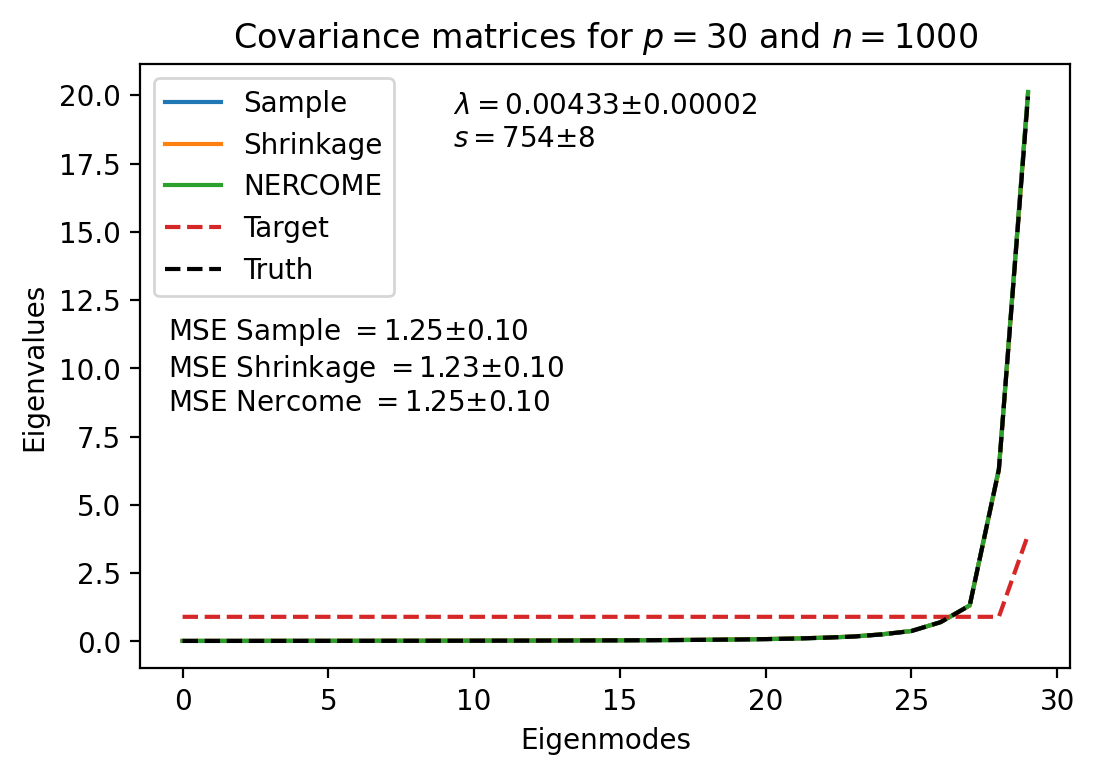

In [36]:
evals_T = np.linalg.eigvalsh(T)
evals_true = np.linalg.eigvalsh(cov)

plt.figure(dpi=200)
plt.plot(evals_MC, label="Sample")
plt.plot(evals_MCS, label="Shrinkage")
plt.plot(evals_NERCOME, label="NERCOME")
plt.plot(evals_T, "--", label="Target")
plt.plot(evals_true, "k--", label="Truth")
plt.legend()
plt.title(fr"Covariance matrices for $p={p}$ and $n={n}$")
plt.xlabel("Eigenmodes")
plt.ylabel("Eigenvalues")

estimator_parameters = AnchoredText(
    fr"$\lambda = 0.00433 ± 0.00002$"
#    fr"$\lambda = {np.round(lmbda_est, 3)} ± {np.round(lmbda_est_se, 3)}$"
    "\n"
#    fr"$s = (7.8 ± 0.4) \cdot 10^2$",
    fr"$s = {int(np.round(s_min, 0))} ± {int(np.round(s_min_se, 0))}$",
    frameon=False, loc="upper center", pad=0.5
)
plt.setp(estimator_parameters.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(estimator_parameters)

error_parameters = AnchoredText(
    fr"MSE Sample $= {float(np.round(MSE_sample, 2))} ± {float(np.round(MSE_sample_se, 2))}$"
#    fr"$MSE Sample = (2.5 ± 0.2) \cdot 10^2$"
    "\n"
    fr"MSE Shrinkage $= {float(np.round(MSE_shrinkage, 2))} ± {float(np.round(MSE_shrinkage_se, 2))}$"
    "\n"
    fr"MSE Nercome $= {float(np.round(MSE_nercome, 2))} ± {float(np.round(MSE_nercome_se, 2))}$",
    frameon=False, loc="center left", pad=0.5
)
plt.setp(error_parameters.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(error_parameters)